Deleting the the following folder if exist in case if we want to re-run the whole notebook.

In [9]:
!rm -rf Images
!rm -rf list_attribute.txt
!rm -rf dataset.zip
!rm -rf gender
!rm -rf train
!rm -rf val
!rm -rf test
!rm -rf female
!rm -rf male

In [10]:
!pip install gdown

In [11]:
# Import library
import os
import shutil
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch and TorchVision library for deep learning
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets, models

# gdown to download file from gdrive
import gdown

# library for visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
!gdown https://drive.google.com/u/0/uc?id=1GKHBT_SmLBi_Lfr4VslU7dI-Wz3WM9cQ&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1GKHBT_SmLBi_Lfr4VslU7dI-Wz3WM9cQ
To: /content/list_attribute.txt
100% 26.7M/26.7M [00:01<00:00, 21.6MB/s]


In [13]:
!gdown https://drive.google.com/u/0/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ&export=download

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ
From (redirected): https://drive.google.com/uc?id=1m0h0XhMnOxxaXjX48zSJT0POPFFK7EPZ&confirm=t&uuid=a3d22469-8288-4422-af45-602792d1c0f7
To: /content/dataset.zip
100% 36.2M/36.2M [00:04<00:00, 7.77MB/s]


In [14]:
!unzip -q dataset.zip

Firstly, we separate the images based on known gender from the file list_attribute.txt and filtering the duplicated files. In the list_attribute.txt, the gender identity is represented as the male column which is located on the 21st column where 1 means male and -1 means female.

In [15]:
attributes = open('list_attribute.txt').readlines()

os.makedirs('/content/male', exist_ok=True)
os.makedirs('/content/female', exist_ok=True)

for line in attributes[2:]:
    clean_attr = [int(x) for x in line.split() if x in ['-1', '1']]

    gender = clean_attr[20]

    parts = line.strip().split()
    filename = parts[0].strip()

    source_path = f'/content/Images/{filename}'

    if os.path.exists(source_path):
        if gender == 1:
            target_path = f'/content/male/{filename}'
        else:
            target_path = f'/content/female/{filename}'

        shutil.copy(source_path, target_path)

        os.remove(source_path)

print('Separating and cleaning process are done')

Separating and cleaning process are done


Visualization of the numer of male and female from the given data.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


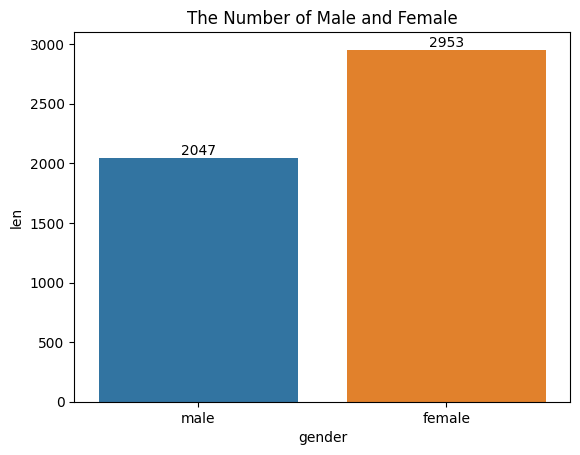

In [16]:
male_images = os.listdir('/content/male')
female_images = os.listdir('/content/female')

len_male = len(male_images)
len_female = len(female_images)

stats = pd.DataFrame({'gender':['male','female'], 'len':[len_male, len_female]})

sns.barplot(data=stats, x='gender', y='len', hue='gender')

for index, value in enumerate(stats['len']):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.title('The Number of Male and Female')

plt.show()

We obtain that the number of male is less than female in this dataset. Separating the data into folders train, val, and test.

In [17]:
os.makedirs('/content/train/male', exist_ok=True)
os.makedirs('/content/val/male', exist_ok=True)
os.makedirs('/content/test/male', exist_ok=True)
os.makedirs('/content/train/female', exist_ok=True)
os.makedirs('/content/val/female', exist_ok=True)
os.makedirs('/content/test/female', exist_ok=True)

male_images = os.listdir('/content/male')
female_images = os.listdir('/content/female')

male_train_val, male_test = train_test_split(male_images, test_size=0.2, random_state=42)
male_train, male_val = train_test_split(male_train_val, test_size=0.25, random_state=42)  # 0.25 dari 0.8 -> 20% val

female_train_val, female_test = train_test_split(female_images, test_size=0.2, random_state=42)
female_train, female_val = train_test_split(female_train_val, test_size=0.25, random_state=42)

def move_images(file_list, source_dir, target_dir):
    for filename in file_list:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.move(source_path, target_path)

# Moving male images to the suitable folder
move_images(male_train, '/content/male', '/content/train/male')
move_images(male_val, '/content/male', '/content/val/male')
move_images(male_test, '/content/male', '/content/test/male')

# Moving female images to the suitable folder
move_images(female_train, '/content/female', '/content/train/female')
move_images(female_val, '/content/female', '/content/val/female')
move_images(female_test, '/content/female', '/content/test/female')

print("Data splitting is done.")

Data splitting is done.


Transformation and its example of visualization. Then, divide the data into some batches using the data_loader.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

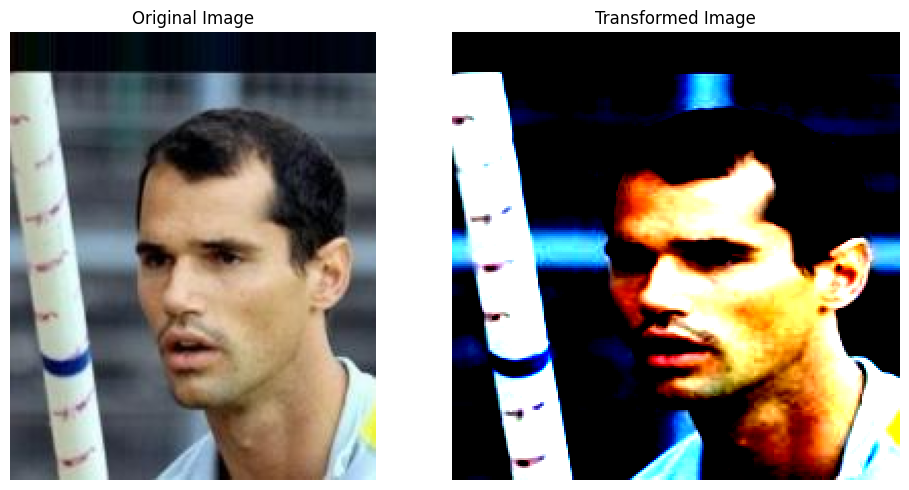

In [ ]:
img_path = './test/male/000409.jpg' # The file location is randomly selected. Because of train test split, this possibly has to be changed.
image = Image.open(img_path)

image_tensor = transform(image)

image_np = image_tensor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Showing the image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Turning off the axis

# Transformed image
axes[1].imshow(image_np)
axes[1].set_title('Transformed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
data_dir = '/content/'

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform)
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}

class_names = image_datasets['train'].classes

# Checking if gpu is available
use_gpu = torch.cuda.is_available()

print(f'Class names: {class_names}')
print(f'Training dataset size: {dataset_sizes["train"]}')
print(f'Validation dataset size: {dataset_sizes["val"]}')
print(f'Test dataset size: {dataset_sizes["test"]}')


Class names: ['female', 'male']
Training dataset size: 2998
Validation dataset size: 1001
Test dataset size: 1001


Visualizing some images from the data.

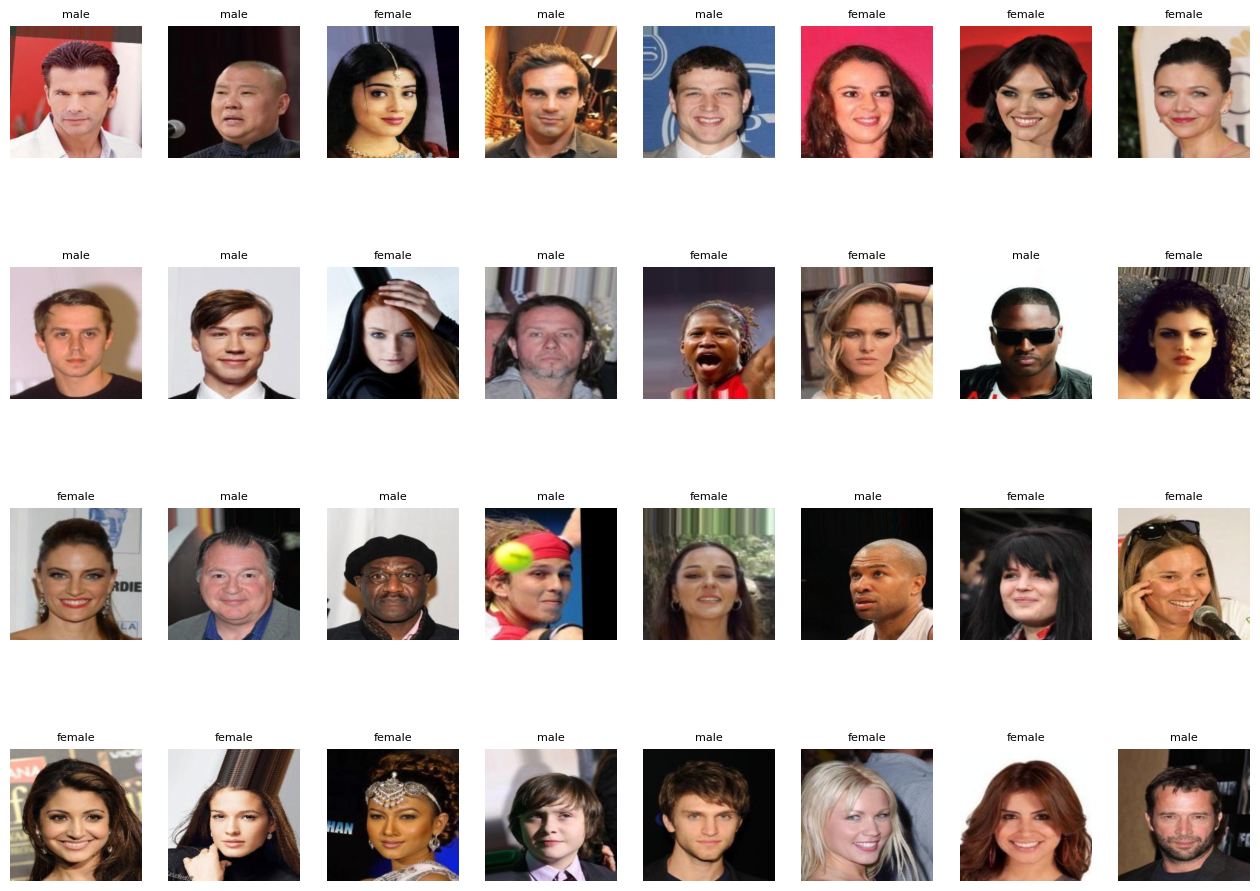

In [ ]:
def imshow_batch_with_labels(inputs, classes, class_names, cols=6, figsize=(12, 8), padding=2):
    inp = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    num_images = len(inputs)

    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        axes[i].imshow(inp[i])
        axes[i].set_title(class_names[classes[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.subplots_adjust(wspace=padding, hspace=padding)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))

imshow_batch_with_labels(inputs, classes, class_names, cols=8, figsize=(16, 12), padding=0.2)

Creating the resnet18 model using pre-trained model as well as constructing the optimizer, loss function, and scheduler.

In [ ]:
# Load ResNet 18
weights = models.ResNet18_Weights.DEFAULT
model_ft = models.resnet18(weights=weights)

# Justify the last fully connected layers with the target labels (in this case, we have 2 labels: male and female)
num_ftrs = model_ft.fc.in_features # getting the number of input features of the model
model_ft.fc = nn.Linear(num_ftrs, 2)

# GPU
if use_gpu:
    model_ft = model_ft.cuda()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# Scheduler to decrese the learning rate gradually once required
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Training process where we will save the obtained weight into a new folder.

In [ ]:
!mkdir gender

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    in_epoch = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Set model into train and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Loop the batches
            for inputs, labels in dataloaders[phase]:

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Zero grad
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimze only if it is in the training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Counting the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./gender/point_resnet18_best.pth')
                in_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(f'In the {in_epoch}/{num_epochs-1} epoch')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2317 Acc: 0.9106
val Loss: 0.1754 Acc: 0.9361

Epoch 1/49
----------
train Loss: 0.1134 Acc: 0.9580
val Loss: 0.1517 Acc: 0.9361

Epoch 2/49
----------
train Loss: 0.0849 Acc: 0.9663
val Loss: 0.1312 Acc: 0.9520

Epoch 3/49
----------
train Loss: 0.0683 Acc: 0.9730
val Loss: 0.0911 Acc: 0.9600

Epoch 4/49
----------
train Loss: 0.0626 Acc: 0.9800
val Loss: 0.1843 Acc: 0.9291

Epoch 5/49
----------
train Loss: 0.0525 Acc: 0.9823
val Loss: 0.1315 Acc: 0.9590

Epoch 6/49
----------
train Loss: 0.0572 Acc: 0.9750
val Loss: 0.1019 Acc: 0.9630

Epoch 7/49
----------
train Loss: 0.0104 Acc: 0.9963
val Loss: 0.0916 Acc: 0.9680

Epoch 8/49
----------
train Loss: 0.0049 Acc: 0.9997
val Loss: 0.0900 Acc: 0.9670

Epoch 9/49
----------
train Loss: 0.0030 Acc: 0.9997
val Loss: 0.0867 Acc: 0.9680

Epoch 10/49
----------
train Loss: 0.0029 Acc: 0.9997
val Loss: 0.0900 Acc: 0.9720

Epoch 11/49
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.0900 Acc: 0.9710

Ep

Visualization of the training process by comparing training vs validation results.

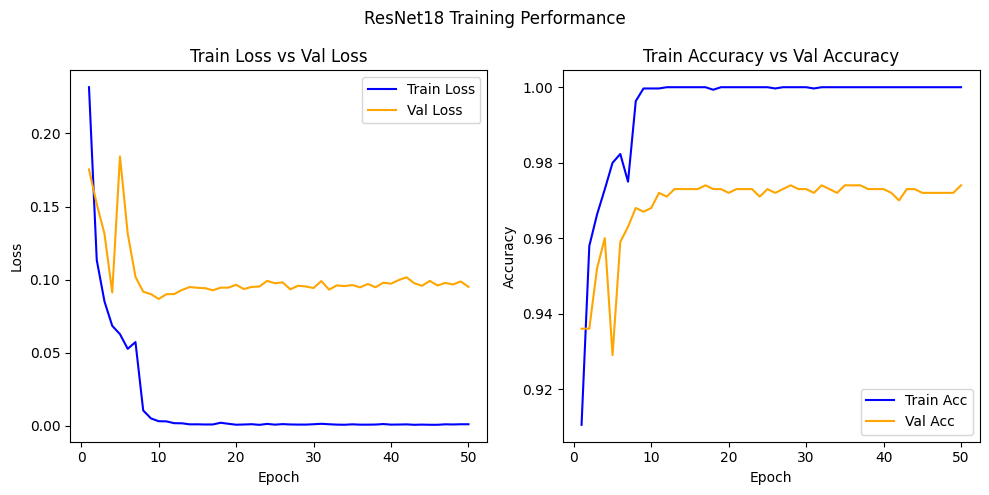

In [ ]:
list_epoch = [i for i in range(1,51)]
train_acc = [float(t.cpu().numpy()) for t in train_acc]
val_acc = [float(t.cpu().numpy()) for t in val_acc]

performance = pd.DataFrame({'epoch':list_epoch, 'train_loss':train_loss, 'train_acc':train_acc, 'val_loss':val_loss, 'val_acc':val_acc})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x='epoch', y='train_loss', data=performance, label='Train Loss', color='blue', ax=axes[0])
sns.lineplot(x='epoch', y='val_loss', data=performance, label='Val Loss', color='orange', ax=axes[0])
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train Loss vs Val Loss')

sns.lineplot(x='epoch', y='train_acc', data=performance, label='Train Acc', color='blue', ax=axes[1])
sns.lineplot(x='epoch', y='val_acc', data=performance, label='Val Acc', color='orange', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train Accuracy vs Val Accuracy')

plt.suptitle('ResNet18 Training Performance')
plt.tight_layout()
plt.show()

Testing the model into new uknown dataset, the training dataset.

In [ ]:
checkpoint = torch.load('./gender/point_resnet18_best.pth', weights_only=True)
model_ft.load_state_dict(checkpoint['model'])
model_ft.eval()

correct = 0
total = 0
total_loss = 0.0
total_batches = 0

with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        total_batches += 1

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

average_loss = total_loss / total_batches
print(f"Average Test Loss: {average_loss:.4f}")

Test Accuracy: 97.10%
Average Test Loss: 0.1253


Visualizing the result of the model.

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()


    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

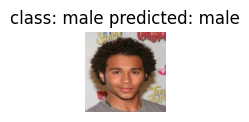

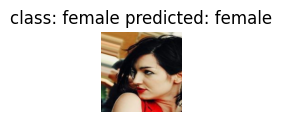

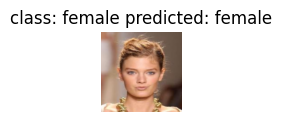

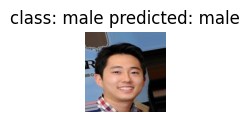

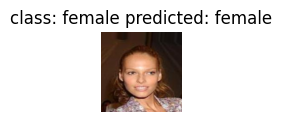

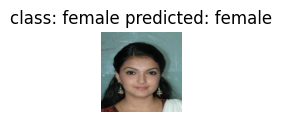

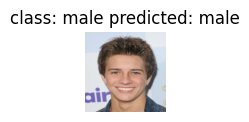

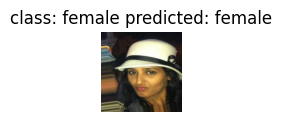

In [ ]:
visualize_model(model_ft, num_images=8)

Downloading the final model weights.

In [ ]:
from google.colab import files
files.download('./gender/point_resnet18_best.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>